In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mlp 

In [71]:
mlp.rc('font',family='Arial',size=11)
monofont = {'fontname':'Monospace', 'fontsize':9}
standardfont = {'fontname':"Arial", 'fontsize':11}
boldfont = {'fontname':"Arial", 'fontsize':11, 'weight':'bold'}

In [113]:
stats_df = pd.read_csv("cycles.csv")

In [35]:
autotune_df = pd.read_csv("autotune.csv")

In [114]:
def ge_flop_count(n):
    return 2/3 * n**3 - 5/2 * n**2 - 1/3 * n - 17/6

def lu_flop_count(n):
    return 2/3 * n**3 - n**2 + 1/3 * n

def tri_flop_count(n, d=30):
    return 3 * n * d - 7/2 * d - d**3 - 5/2 * d**2 + ge_flop_count(n-d) 

In [36]:
ge_tags = ["GE_Solve_Base", "GE_Solve_Loop_Unroll", "GE_Solve_Naive_Vector"]
lu_tags = ["LU_Solve_Basic_C_Opts", "LU_Solve_Transposed", "LU_Solve_Transposed_Vector", "LU_Solve_Intel_DGESV_Row_Major"]
tri_tags = ["Triangular_System_Solve_Base", "Triangular_System_Solve_Loop_Unroll", "Triangular_System_Solve_Vectorized"]

# the following should all be of same size:
sizes = [] 
ge_perfs_dict = {} # of form [tag : cycles] where |cycles| = |size|
lu_perfs_dict = {} # of form [tag : cycles] where |cycles| = |size|
tri_perfs_dict = {}

In [37]:
lu_block_tags= ["LU_Solve Transposed Vector (sqrt)",\
"LU_Solve Transposed Vector (32)",\
"LU_Solve Transposed Vector (64)",\
"LU_Solve Transposed Vector (128)",\
"LU_Solve Transposed Vector (256)",\
"LU_Solve Transposed Vector (512)"]
# "LU_Solve Transposed Vector (sqrt)"]

sizes = []
lu_block_perfs_dict = {}

In [8]:
# collect_size
def collect_sizes(df):
    return df['size'].sort_values().unique()

In [9]:
def collect_perfs(tag, df):
    tagged_df = df.loc[df['tag'] == tag].sort_values('size')
    perfs = []
    for index, row in tagged_df.iterrows():
        perfs.append(row['cycles'])
        
    return perfs

In [118]:
for _, f_tag in enumerate(ge_tags):
    ge_perfs_dict[f_tag] = collect_perfs(f_tag, stats_df)


In [119]:
for _, f_tag in enumerate(lu_tags):
    lu_perfs_dict[f_tag] = collect_perfs(f_tag, stats_df)

In [120]:
for _, f_tag in enumerate(tri_tags):
    tri_perfs_dict[f_tag] = collect_perfs(f_tag, stats_df)

# Basic cycles against size

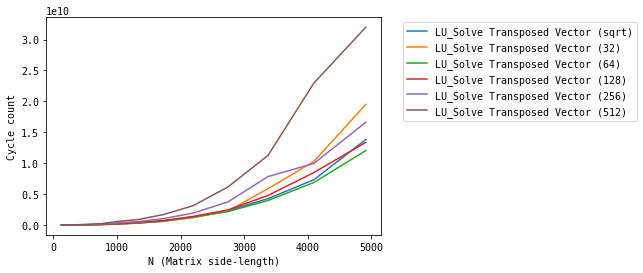

In [40]:
# for tag in ge_tags:
#     plt.plot(sizes, ge_perfs_dict[tag], label=tag)
# for tag in lu_tags:
#     plt.plot(sizes, lu_perfs_dict[tag], label=tag)
# for tag in tri_tags:
#     plt.plot(sizes, tri_perfs_dict[tag], label=tag)

for tag in lu_block_tags:
        plt.plot(sizes, lu_block_perfs_dict[tag], label=tag)
# plt.plot(sizes, ge_perfs_dict["GE_Solve_Naive_Vector"], label="Standard GE Vectorized")
# plt.plot(sizes, tri_perfs_dict["Triangular_System_Solve_Vectorized"], label="Block Triangular GE Vectorized")

# plt.xscale("function", functions=(lambda x: x**(3), lambda x:x**(1/3)))
# plt.gca().set_xlim(0, 2744)
# plt.gca().set_ylim(0, 1.0e11)

# plt.legend(bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
        #    bbox_transform=plt.gcf().transFigure)
plt.legend(bbox_to_anchor=(1.05, 1.00))

# plt.xticks([0, 1100, 1500, 1750, 2000, 2250, 2500, 2744])

# plt.text(2100, 0.85e10, "Standard GE Vectorized", rotation=30, **monofont)
# plt.text(2100, 0.5e10, "Block Triangular GE Vectorized", rotation=27, **monofont)

plt.gca().set_xlabel("N (Matrix side-length)")
plt.gca().set_ylabel("Cycle count")

# plt.savefig('./comp_tri_ge.pdf')

plt.show()

# Flops per cycle plots

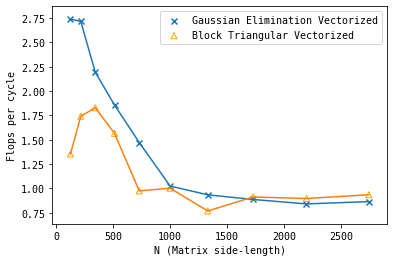

In [123]:
ge_flops_per_cycle = [ge_flop_count(size)  / cycles for (size, cycles) in zip(sizes, ge_perfs_dict["GE_Solve_Naive_Vector"])]

lu_flops_per_cycle = [lu_flop_count(size) / cycles for (size, cycles) in zip(sizes, lu_perfs_dict["LU_Solve_Basic_C_Opts"])]
lu_1_flops_per_cycle = [lu_flop_count(size) / cycles for (size, cycles) in zip(sizes, lu_perfs_dict["LU_Solve_Transposed_Vector"])]
lu_2_flops_per_cycle = [lu_flop_count(size) / cycles for (size, cycles) in zip(sizes, lu_perfs_dict["LU_Solve_Intel_DGESV_Row_Major"])]
tri_flops_per_cycle = [tri_flop_count(size, 30) / cycles for (size, cycles) in zip(sizes, tri_perfs_dict["Triangular_System_Solve_Vectorized"])]

plt.plot(sizes, ge_flops_per_cycle)
plt.scatter(sizes, ge_flops_per_cycle, label="Gaussian Elimination Vectorized", marker="x", edgecolors='blue')
plt.plot(sizes, tri_flops_per_cycle)
plt.scatter(sizes, tri_flops_per_cycle, label="Block Triangular Vectorized", marker="^", facecolors='none', edgecolors='orange')
# plt.plot(sizes, lu_1_flops_per_cycle)
# plt.scatter(sizes, lu_1_flops_per_cycle, label="LU Transposed Vectorized", marker="s", facecolors='none', edgecolors='green')

# plt.gca().set_ylim(0, 100)

plt.gca().set_xlabel("N (Matrix side-length)")
plt.gca().set_ylabel("Flops per cycle")

lgd = plt.legend()#bbox_to_anchor=(1.05, 1.00))

plt.savefig('./flops_per_cycle_block_tri.pdf', bbox_inches='tight')

plt.show()

# MMM

In [3]:
mmm_df = pd.read_csv("mmm_cycles.csv")

In [4]:
def mmm_flop_count(n):
    return 2 * n**3

In [5]:
mmm_tags = ["MMM Base", "MMM_C_opts", "MMM_Copts_Vector", "MMM_Intel"]

sizes_mmm = [] 
mmm_perfs_dict = {}

In [6]:
sizes_mmm = mmm_df['size'].sort_values().unique()

In [10]:
for _, f_tag in enumerate(mmm_tags):
    mmm_perfs_dict[f_tag] = collect_perfs(f_tag, mmm_df)

In [11]:
print(mmm_perfs_dict)

{'MMM Base': [61973.4, 475210.0, 6141620.0, 101246000.0, 1317330000.0, 29014400000.0], 'MMM_C_opts': [61729.7, 344983.0, 3640310.0, 30496800.0, 290898000.0, 2462910000.0], 'MMM_Copts_Vector': [8861.36, 57944.2, 419801.0, 3792250.0, 33471600.0, 260875000.0], 'MMM_Intel': [6123.2, 29470.1, 190432.0, 2901380.0, 21486500.0, 163295000.0]}


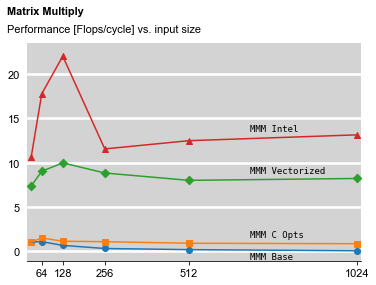

In [82]:
mmm_base_flops_per_cycle = [mmm_flop_count(size)  / cycles for (size, cycles) in zip(sizes_mmm, mmm_perfs_dict[mmm_tags[0]])]
mmm_1_flops_per_cycle = [mmm_flop_count(size)  / cycles for (size, cycles) in zip(sizes_mmm, mmm_perfs_dict[mmm_tags[1]])]
mmm_2_flops_per_cycle = [mmm_flop_count(size)  / cycles for (size, cycles) in zip(sizes_mmm, mmm_perfs_dict[mmm_tags[2]])]
mmm_3_flops_per_cycle = [mmm_flop_count(size)  / cycles for (size, cycles) in zip(sizes_mmm, mmm_perfs_dict[mmm_tags[3]])]

plt.gca().set_axisbelow(True)
plt.gca().set_facecolor('lightgray')
# plt.gca().set_
plt.grid(axis='y', linewidth=2.5, color="white")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

for tic in plt.gca().yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
    # tic.tick1On = tic.tick2On = False

plt.plot(sizes_mmm, mmm_base_flops_per_cycle)
plt.scatter(sizes_mmm, mmm_base_flops_per_cycle, label="MMM Base", marker="o")
plt.plot(sizes_mmm, mmm_1_flops_per_cycle)
plt.scatter(sizes_mmm, mmm_1_flops_per_cycle, label="MMM C Opts", marker="s")
plt.plot(sizes_mmm, mmm_2_flops_per_cycle)
plt.scatter(sizes_mmm, mmm_2_flops_per_cycle, label="MMM Vectorized", marker="D")
plt.plot(sizes_mmm, mmm_3_flops_per_cycle)
plt.scatter(sizes_mmm, mmm_3_flops_per_cycle, label="MMM Intel", marker="^")

plt.text(700, 13.5, "MMM Intel", fontdict=monofont)
plt.text(700, 8.8, "MMM Vectorized", fontdict=monofont)
plt.text(700, 1.6, "MMM C Opts", fontdict=monofont)
plt.text(700, -0.85, "MMM Base", fontdict=monofont)

plt.xticks([0] + sizes_mmm[1:])

# plt.gca().set_ylim(0, 100)

# plt.gca().set_xlabel("N (Matrix side-length)")
# plt.gca().set_ylabel("Flops per cycle")

# lgd = plt.legend(bbox_to_anchor=(1.40, 1.00))

plt.gca().autoscale(enable=True, axis='x', tight=True)
# plt.gca().set_xlim(0,1024)

plt.figtext(0.08, 0.92, "Performance [Flops/cycle] vs. input size")
plt.figtext(0.08, 0.98, "Matrix Multiply", **boldfont)

plt.savefig('./flops_per_cycle_mmm.pdf', bbox_inches='tight')

plt.show()

# Surrogate eval

In [30]:
surr_eval_df = pd.read_csv("surrogate_eval.csv")

In [31]:
surr_eval_tags = [f"surrogate_eval_{i}" for i in range(0, 6)]
# surr_eval_labels = ["Surrogate Eval Base", ""]

surr_eval_perf_dicts = {}

In [32]:
sizes = collect_sizes(surr_eval_df)

In [33]:
for _, f_tag in enumerate(surr_eval_tags):
    surr_eval_perf_dicts[f_tag] = collect_perfs(f_tag, surr_eval_df)

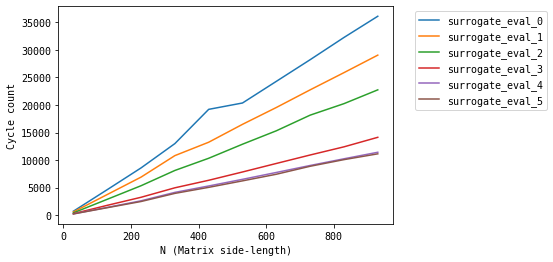

In [34]:
for tag in surr_eval_tags:
    plt.plot(sizes, surr_eval_perf_dicts[tag], label=tag)

# plt.xscale("function", functions=(lambda x: x**(3), lambda x:x**(1/3)))
# plt.gca().set_xlim(0, 2744)
# plt.gca().set_ylim(0, 1.0e11)

# plt.legend(bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
        #    bbox_transform=plt.gcf().transFigure)
plt.legend(bbox_to_anchor=(1.05, 1.00))

# plt.xticks([0, 1100, 1500, 1750, 2000, 2250, 2500, 2744])

# plt.text(2100, 0.85e10, "Standard GE Vectorized", rotation=30, **monofont)
# plt.text(2100, 0.5e10, "Block Triangular GE Vectorized", rotation=27, **monofont)

plt.gca().set_xlabel("N (Matrix side-length)")
plt.gca().set_ylabel("Cycle count")

# plt.savefig('./comp_tri_ge.pdf')

plt.show()

# Fit surrogate

In [ ]:
# Surrogate eval

In [37]:
fit_surr_df = pd.read_csv("fit_surrogate.csv")

In [39]:
fit_surr_tags = [f"fit_surrogate_{i}" for i in range(0, 6)]
fit_surr_tags += [f"fit_surrogate_6_LU_{i}" for i in range(0, 7)]
fit_surr_tags += ["fit_surrogate_6_GE", "fit_surrogate_6_TRI"]
# surr_eval_labels = ["Surrogate Eval Base", ""]

fit_surr_perf_dict = {}

In [41]:
sizes = collect_sizes(fit_surr_df)

In [42]:
for _, f_tag in enumerate(fit_surr_tags):
    fit_surr_perf_dict[f_tag] = collect_perfs(f_tag, fit_surr_df)

ValueError: x and y must have same first dimension, but have shapes (27,) and (11,)

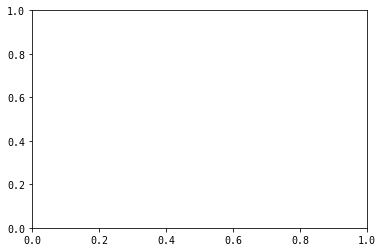

In [43]:
for tag in fit_surr_tags:
    plt.plot(sizes, fit_surr_perf_dict[tag], label=tag)

# plt.xscale("function", functions=(lambda x: x**(3), lambda x:x**(1/3)))
# plt.gca().set_xlim(0, 2744)
# plt.gca().set_ylim(0, 1.0e11)

# plt.legend(bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
        #    bbox_transform=plt.gcf().transFigure)
plt.legend(bbox_to_anchor=(1.05, 1.00))

# plt.xticks([0, 1100, 1500, 1750, 2000, 2250, 2500, 2744])

# plt.text(2100, 0.85e10, "Standard GE Vectorized", rotation=30, **monofont)
# plt.text(2100, 0.5e10, "Block Triangular GE Vectorized", rotation=27, **monofont)

plt.gca().set_xlabel("N (Matrix side-length)")
plt.gca().set_ylabel("Cycle count")

# plt.savefig('./comp_tri_ge.pdf')

plt.show()